# Question 3: CIFAR-10 Classification using CNN 
- Please **do not** change the default variable names in this problem, as we will use them in different parts.
- The default variables are initially set to "None".


In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import *
import random 
from tqdm import tqdm 
import warnings 

In [2]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()

Files already downloaded and verified
Files already downloaded and verified


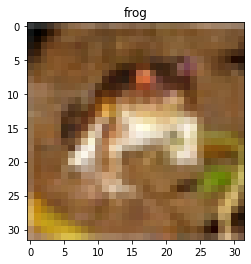

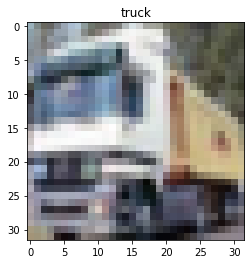

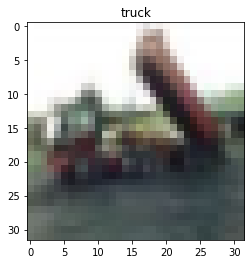

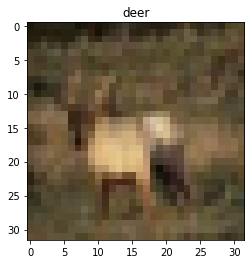

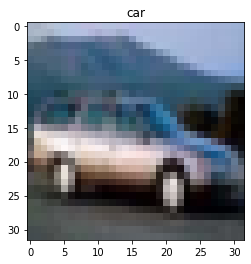

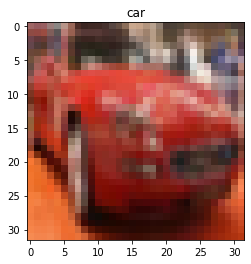

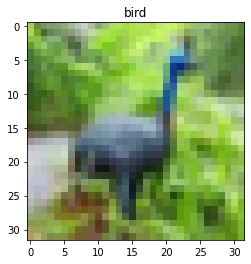

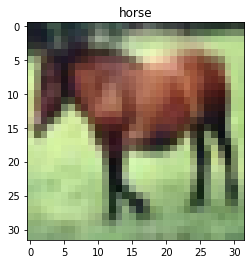

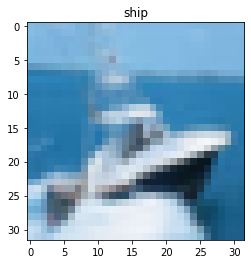

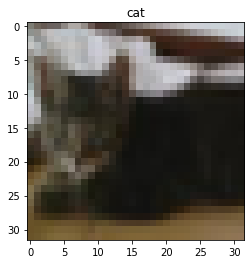

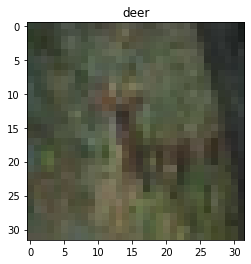

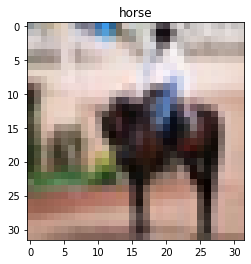

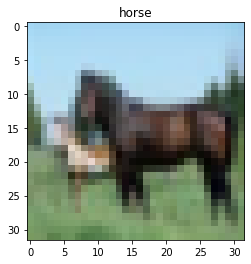

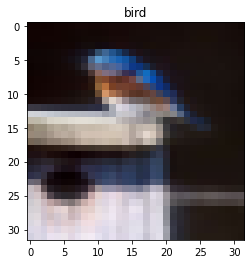

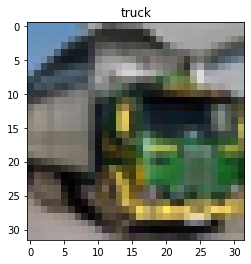

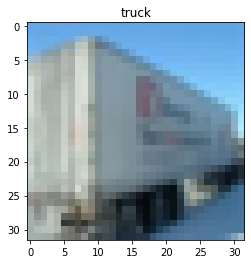

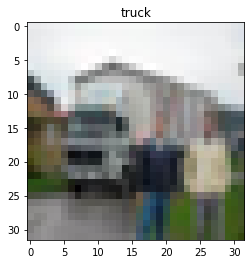

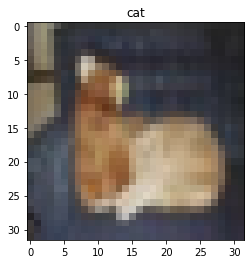

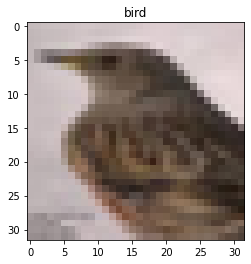

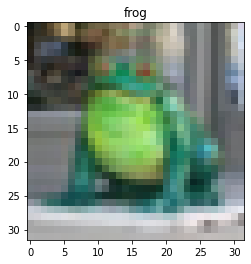

In [3]:

# The below two lines are optional and are just there to avoid any SSL
# related errors while downloading the CIFAR-10 dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#Initializing normalizing transform for the dataset
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5),
                                    std = (0.5, 0.5, 0.5))])

#Downloading the CIFAR10 dataset into train and test sets
train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)
    
test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)


#Generating data loaders from the corresponding datasets
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)




classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
'frog', 'horse', 'ship', 'truck')

# get first 100 training images
dataiter = iter(train_loader)
imgs, lbls = dataiter.next()

for i in range(20):  
    plt.title(classes[lbls[i]])
    imshow(imgs[i])

In [4]:
# check pytorch cuda and use cuda if possible
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on NVIDIA GeForce RTX 2070 SUPER.......


## P1. Build you own CNN model 
### TODO
- Design your model class in **CNNModel(nn.Module)** and write forward pass in **forward(self, x)**
- Create loss function in **error**, optimizer in **optimizer**
- Define hyparparameters: **learning_rate**, **num_epochs**
- Plot your **loss vs num_epochs** and **accuracy vs num_epochs** 


###  Hints
- Start with low number of epochs for debugging. (eg. num_epochs=1)
- Be careful with the input dimension of fully connected layer. 
- The dimension calculation of the output tensor from the input tensor is \\
$D_{out}=\frac{D_{in}-K+2P}{S}+1$ \\
$D_{out}$ : Dimension of output tensor \\
$D_{in}$ : Dimension of input tensor \\
$K$ : width/height of the kernel \\
$S$ : stride \\
$P$ : padding

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
For example:
```
torch.nn.Conv2d(3, 32, 3)
```
It applies a 2D convolution over an input signal composed of several input planes. If we have input size with $(N, C_{in}, H, W)$ and output size with $(N, C_{out}, H_{out}, W_{out})$, the 2D convolution can described as $$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_{in}-1}weight(C_{out_j},k)\star input(N_i,k)$$

**num_in_channels:** is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

**num_out_channels:** is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

**kernel_size:** is the size of the convolving kernel

**stride:** is the stride of the convolution. Default: 1

**padding:** is the padding added to all four sides of the input. Default: 0

**dilation:** is the spacing between kernel elements. Default: 1

**group:** is the number of blocked connections from input channels to output channels. Default: 1

**bias:** If True, adds a learnable bias to the output. Default: True

## A Simple Convolutional Neural Network

In our convnet we'll initally use this structure shown below:

*input -> convolution -> fully connected -> output* \\


At the end of the last convolutional layer, we get a tensor of dimension (num_channels, height, width). Since now we are going to feed it to a fully connected layer, we need to convert it into a 1-D vector, and for that we use the reshape method:

```
x = x.view(x.size(0), -1)
```
The way of calculating size of the output size from previous convolution layer can be formulized as below: $$H_{output} = \frac{H_{in}+2\times padding-kernel\_Size}{stride}+1$$

For more details, you can refer to this link: \\
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [26]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    
    # convolution layer 1. using kernel_size = 5 to obtain the output of 28x28
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)   
    self.relu1 = nn.ReLU() 
    
    # convolution layer 2. using kernel_size = 3 to obtain the output of 26x26
    self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)   
    self.relu2 = nn.ReLU()
    
    # convolution layer 3. using kernel_size = 3 to obtain the output of 24x24    
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)   
    self.relu3 = nn.ReLU() 
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    
    # Fully connected 1
    self.fc1 = nn.Linear(24 * 24 * 24, 120)
    self.relu4 = nn.ReLU()
    
    # Fully connected 2
    self.fc2 = nn.Linear(120, 84)
    self.relu5 = nn.ReLU()
    
    # Fully connected 3
    self.fc3 = nn.Linear(84, 10)
    
    self.i = 0

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    out = self.cnn1(x)
    out = self.relu1(out)      
    out = self.cnn2(out)
    out = self.relu2(out)
    
    if self.i == 0:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.i += 1

    out = self.cnn3(out)
    out = self.relu3(out)
    
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)    
    out = self.fc3(out)    
    
    return out

## Starting Up Our Model

We'll send the model to our GPU if you have one so we need to create a CUDA device and instantiate our model. Then we will define the loss function and 
hyperparameters that we need to train the model: \\

###TODO
- Define Cross Entropy Loss
- Create Adam Optimizer
- Define hyperparameters 

In [27]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

### Training the Model
### TODO 
- Make predictions from your model
- Calculate Cross Entropy Loss from predictions and labels 

  0%|          | 0/20 [00:00<?, ?it/s]

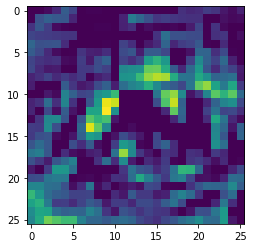

  5%|▌         | 1/20 [00:19<06:01, 19.03s/it]

Iteration: 500  Loss: 1.33452570438385  Accuracy: 52.84000015258789 %


 10%|█         | 2/20 [00:39<05:57, 19.84s/it]

Iteration: 1000  Loss: 1.1488442420959473  Accuracy: 58.63999938964844 %


 15%|█▌        | 3/20 [00:59<05:41, 20.06s/it]

Iteration: 1500  Loss: 0.913888156414032  Accuracy: 61.1099967956543 %


 25%|██▌       | 5/20 [01:40<05:03, 20.25s/it]

Iteration: 2000  Loss: 0.8821907043457031  Accuracy: 60.56999969482422 %


 30%|███       | 6/20 [01:59<04:36, 19.77s/it]

Iteration: 2500  Loss: 0.7237609028816223  Accuracy: 59.119998931884766 %


 35%|███▌      | 7/20 [02:19<04:19, 19.97s/it]

Iteration: 3000  Loss: 0.8468115925788879  Accuracy: 55.03999710083008 %


 40%|████      | 8/20 [02:40<04:00, 20.08s/it]

Iteration: 3500  Loss: 0.5502995252609253  Accuracy: 55.209999084472656 %


 50%|█████     | 10/20 [03:20<03:22, 20.22s/it]

Iteration: 4000  Loss: 0.5978149175643921  Accuracy: 51.44999694824219 %


 55%|█████▌    | 11/20 [03:41<03:02, 20.26s/it]

Iteration: 4500  Loss: 0.4748920500278473  Accuracy: 53.459999084472656 %


 60%|██████    | 12/20 [03:59<02:38, 19.81s/it]

Iteration: 5000  Loss: 0.41435378789901733  Accuracy: 51.709999084472656 %


 70%|███████   | 14/20 [04:40<02:00, 20.05s/it]

Iteration: 5500  Loss: 0.5298575162887573  Accuracy: 53.89999771118164 %


 75%|███████▌  | 15/20 [05:00<01:40, 20.13s/it]

Iteration: 6000  Loss: 0.6019865870475769  Accuracy: 50.04999923706055 %


 80%|████████  | 16/20 [05:21<01:20, 20.18s/it]

Iteration: 6500  Loss: 0.5004005432128906  Accuracy: 50.369998931884766 %


 85%|████████▌ | 17/20 [05:39<00:59, 19.76s/it]

Iteration: 7000  Loss: 0.3183412253856659  Accuracy: 52.16999816894531 %


 95%|█████████▌| 19/20 [06:20<00:20, 20.02s/it]

Iteration: 7500  Loss: 0.20209279656410217  Accuracy: 51.59000015258789 %


100%|██████████| 20/20 [06:40<00:00, 20.03s/it]


In [28]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

In [29]:
# !pip install torchsummary
# uncomment above line if you don't have torchsummary installed yet
# Print torchsummary of model
from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,480
              ReLU-6           [-1, 24, 24, 24]               0
            Linear-7                  [-1, 120]       1,659,000
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 1,674,830
Trainable params: 1,674,830
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.45
Params size (MB): 6.39
Estimated Total Size (MB): 6.85
---------------------------------------

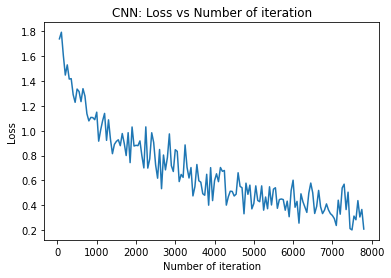

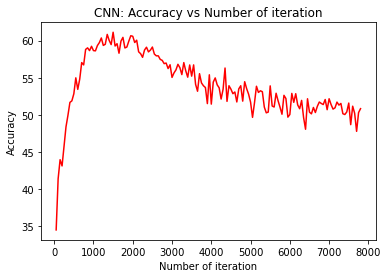

In [30]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

### Evaluating the Model

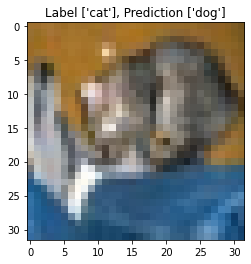

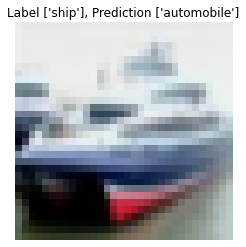

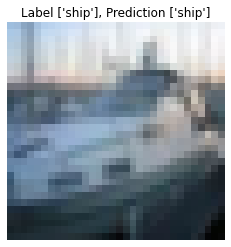

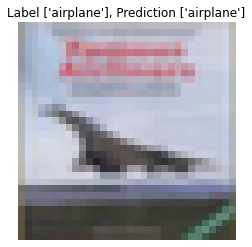

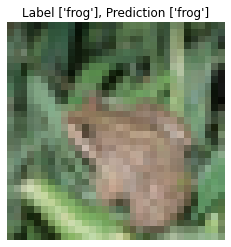

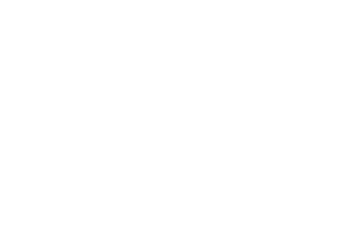

In [33]:

#To-do: evaluate on test set, instead of training set
random_image = random.randint(0,len(test_dataset))
image = test_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols=1
num_rows = 5# len(labels)
label_map = [['airplane'],['automobile'],['bird'],['cat'], ['deer'], ['dog'], ['frog'], ['horse'], ['ship'], ['truck']]

for idx in range(num_rows):
  img = images.cpu()[idx]
  
  plt.title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")  
  imshow(img)

  plt.axis('off')
plt.show()

In [36]:
class CNNModel2(nn.Module):
  def __init__(self):
    super(CNNModel2, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    
    # convolution layer 1. using kernel_size = 5 to obtain the output of 28x28
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)   
    self.relu1 = nn.ReLU() 
    
    # convolution layer 2. using kernel_size = 3 to obtain the output of 26x26
    self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)   
    self.relu2 = nn.ReLU()
    # maxpool layer 1 added to obtain output of 13x13
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    
    # convolution layer 3. using kernel_size = 3 to obtain the output of 11x11    
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)   
    self.relu3 = nn.ReLU() 
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    
    # Fully connected 1
    self.fc1 = nn.Linear(24 * 11 * 11, 120)
    self.relu4 = nn.ReLU()
    
    # Fully connected 2
    self.fc2 = nn.Linear(120, 84)
    self.relu5 = nn.ReLU()
    
    # Fully connected 3
    self.fc3 = nn.Linear(84, 10)
    
    self.i = 0

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    out = self.cnn1(x)
    out = self.relu1(out)      
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool1(out)
    
    if self.i == 0:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.i += 1

    out = self.cnn3(out)
    out = self.relu3(out)
    
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)    
    out = self.fc3(out)    
    
    return out

In [37]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = CNNModel2()
model2.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 

optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)


  0%|          | 0/20 [00:00<?, ?it/s]

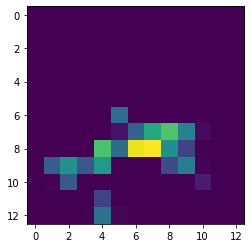

  5%|▌         | 1/20 [00:19<06:03, 19.11s/it]

Iteration: 500  Loss: 1.340271234512329  Accuracy: 51.28999710083008 %


 10%|█         | 2/20 [00:39<05:58, 19.92s/it]

Iteration: 1000  Loss: 1.136545181274414  Accuracy: 59.029998779296875 %


 15%|█▌        | 3/20 [00:59<05:42, 20.12s/it]

Iteration: 1500  Loss: 0.966973066329956  Accuracy: 61.46999740600586 %


 25%|██▌       | 5/20 [01:40<05:04, 20.29s/it]

Iteration: 2000  Loss: 0.9164866209030151  Accuracy: 63.22999954223633 %


 30%|███       | 6/20 [01:59<04:38, 19.88s/it]

Iteration: 2500  Loss: 1.0408035516738892  Accuracy: 64.33000183105469 %


 35%|███▌      | 7/20 [02:20<04:20, 20.05s/it]

Iteration: 3000  Loss: 1.1702224016189575  Accuracy: 64.4000015258789 %


 40%|████      | 8/20 [02:40<04:02, 20.19s/it]

Iteration: 3500  Loss: 0.7907053232192993  Accuracy: 65.05999755859375 %


 50%|█████     | 10/20 [03:21<03:23, 20.34s/it]

Iteration: 4000  Loss: 0.7402896881103516  Accuracy: 62.369998931884766 %


 55%|█████▌    | 11/20 [03:42<03:03, 20.37s/it]

Iteration: 4500  Loss: 0.6377255320549011  Accuracy: 64.15999603271484 %


 60%|██████    | 12/20 [04:01<02:39, 19.95s/it]

Iteration: 5000  Loss: 0.7986494898796082  Accuracy: 64.18000030517578 %


 70%|███████   | 14/20 [04:42<02:01, 20.28s/it]

Iteration: 5500  Loss: 0.7745624780654907  Accuracy: 63.34000015258789 %


 75%|███████▌  | 15/20 [05:02<01:41, 20.32s/it]

Iteration: 6000  Loss: 0.5210683941841125  Accuracy: 63.23999786376953 %


 80%|████████  | 16/20 [05:23<01:21, 20.33s/it]

Iteration: 6500  Loss: 0.7801148295402527  Accuracy: 63.21999740600586 %


 85%|████████▌ | 17/20 [05:42<00:59, 19.89s/it]

Iteration: 7000  Loss: 0.7312436103820801  Accuracy: 64.0999984741211 %


 95%|█████████▌| 19/20 [06:22<00:20, 20.12s/it]

Iteration: 7500  Loss: 0.8021711111068726  Accuracy: 62.18000030517578 %


100%|██████████| 20/20 [06:43<00:00, 20.15s/it]


In [38]:
count = 0
loss_list2 = []
iteration_list2 = []
accuracy_list2 = []
for epoch in tqdm(range(num_epochs)):
    model2.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer2.zero_grad()
        
        # TODO: Forward propagation
        outputs = model2(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer2.step()
        
        count += 1
        
        if count % 50 == 0:
            model2.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model2(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list2.append(loss.item())
            iteration_list2.append(count)
            accuracy_list2.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

In [39]:
from torchsummary import summary
print(summary(model2, input_size=(3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 24, 11, 11]           3,480
              ReLU-7           [-1, 24, 11, 11]               0
            Linear-8                  [-1, 120]         348,600
            Linear-9                   [-1, 84]          10,164
           Linear-10                   [-1, 10]             850
Total params: 364,430
Trainable params: 364,430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.30
Params size (MB): 1.39
Estimated T

Adding the maxpool layer reduces the memory of the model by 6 MB, basically using 1/6 the amount of memory.

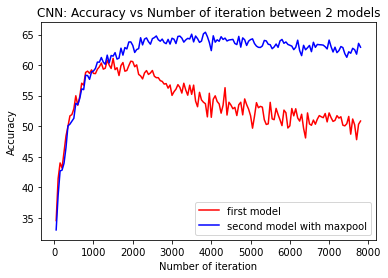

In [41]:
# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.plot(iteration_list2,accuracy_list2,color = "blue")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration between 2 models")
plt.legend(['first model', 'second model with maxpool'])
plt.show()

Adding the maxpool layer noticeably improved the accuracy of the model. The original model seems to start overfitting after around 2000 iterations, with the accuracy after that dropping. Adding the maxpool layer in the second model helps reduce the overfitting and gives a stable accuracy.

In [42]:
class CNNModel3(nn.Module):
  def __init__(self):
    super(CNNModel3, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    
    # convolution layer 1. using kernel_size = 5 to obtain the output of 28x28
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)   
    self.relu1 = nn.ReLU() 
    
    # convolution layer 2. using kernel_size = 3 to obtain the output of 26x26
    self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)   
    self.relu2 = nn.ReLU()
    # maxpool layer 1 added to obtain output of 13x13
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    
    # convolution layer 3. using kernel_size = 3 to obtain the output of 11x11    
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)   
    self.relu3 = nn.ReLU() 
    
    # convolution layer 4. using kernel_size = 3 to obtain the output of 9x9    
    self.cnn4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=0)   
    self.relu4 = nn.ReLU() 
    
    # convolution layer 5. using kernel_size = 3 to obtain the output of 7x7    
    self.cnn5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=0)   
    self.relu5 = nn.ReLU() 
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    
    # Fully connected 1
    self.fc1 = nn.Linear(24 * 7 * 7, 120)
    self.relu4 = nn.ReLU()
    
    # Fully connected 2
    self.fc2 = nn.Linear(120, 84)
    self.relu5 = nn.ReLU()
    
    # Fully connected 3
    self.fc3 = nn.Linear(84, 10)
    
    self.i = 0

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    out = self.cnn1(x)
    out = self.relu1(out)      
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool1(out)
    
    if self.i == 0:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.i += 1

    out = self.cnn3(out)
    out = self.relu3(out)
    out = self.cnn4(out)
    out = self.relu4(out)
    out = self.cnn5(out)
    out = self.relu5(out)
    
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)    
    out = self.fc3(out)    
    
    return out

In [43]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = CNNModel3()
model3.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 

optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)


  0%|          | 0/20 [00:00<?, ?it/s]

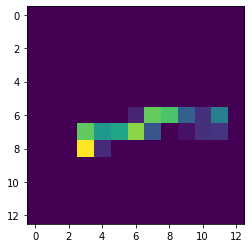

  5%|▌         | 1/20 [00:19<06:12, 19.62s/it]

Iteration: 500  Loss: 1.4272009134292603  Accuracy: 47.19999694824219 %


 10%|█         | 2/20 [00:40<06:05, 20.30s/it]

Iteration: 1000  Loss: 1.269968867301941  Accuracy: 51.40999984741211 %


 15%|█▌        | 3/20 [01:01<05:48, 20.52s/it]

Iteration: 1500  Loss: 1.0139206647872925  Accuracy: 57.34000015258789 %


 25%|██▌       | 5/20 [01:42<05:09, 20.66s/it]

Iteration: 2000  Loss: 1.1258167028427124  Accuracy: 58.099998474121094 %


 30%|███       | 6/20 [02:02<04:42, 20.21s/it]

Iteration: 2500  Loss: 1.1712369918823242  Accuracy: 60.54999923706055 %


 35%|███▌      | 7/20 [02:22<04:25, 20.39s/it]

Iteration: 3000  Loss: 1.2697153091430664  Accuracy: 61.209999084472656 %


 40%|████      | 8/20 [02:43<04:06, 20.51s/it]

Iteration: 3500  Loss: 0.9665572047233582  Accuracy: 62.39999771118164 %


 50%|█████     | 10/20 [03:25<03:26, 20.64s/it]

Iteration: 4000  Loss: 0.9614195227622986  Accuracy: 61.96999740600586 %


 55%|█████▌    | 11/20 [03:45<03:06, 20.67s/it]

Iteration: 4500  Loss: 0.9483880996704102  Accuracy: 62.18000030517578 %


 60%|██████    | 12/20 [04:05<02:42, 20.26s/it]

Iteration: 5000  Loss: 0.9546028971672058  Accuracy: 63.75 %


 70%|███████   | 14/20 [04:46<02:03, 20.53s/it]

Iteration: 5500  Loss: 0.9173708558082581  Accuracy: 64.18999481201172 %


 75%|███████▌  | 15/20 [05:07<01:43, 20.60s/it]

Iteration: 6000  Loss: 0.7497398853302002  Accuracy: 64.26000213623047 %


 80%|████████  | 16/20 [05:28<01:22, 20.68s/it]

Iteration: 6500  Loss: 0.9469053745269775  Accuracy: 64.33000183105469 %


 85%|████████▌ | 17/20 [05:47<01:00, 20.28s/it]

Iteration: 7000  Loss: 0.820540726184845  Accuracy: 63.88999938964844 %


 95%|█████████▌| 19/20 [06:29<00:20, 20.53s/it]

Iteration: 7500  Loss: 0.9097587466239929  Accuracy: 65.38999938964844 %


100%|██████████| 20/20 [06:50<00:00, 20.50s/it]


In [44]:
count = 0
loss_list3 = []
iteration_list3 = []
accuracy_list3 = []
for epoch in tqdm(range(num_epochs)):
    model3.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer3.zero_grad()
        
        # TODO: Forward propagation
        outputs = model3(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer3.step()
        
        count += 1
        
        if count % 50 == 0:
            model3.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model3(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list3.append(loss.item())
            iteration_list3.append(count)
            accuracy_list3.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

In [45]:
from torchsummary import summary
print(summary(model3, input_size=(3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 24, 11, 11]           3,480
              ReLU-7           [-1, 24, 11, 11]               0
            Conv2d-8             [-1, 24, 9, 9]           5,208
              ReLU-9             [-1, 24, 9, 9]               0
           Conv2d-10             [-1, 24, 7, 7]           5,208
             ReLU-11             [-1, 24, 7, 7]               0
           Linear-12                  [-1, 120]         141,240
           Linear-13                   [-1, 84]          10,164
           Linear-14                   

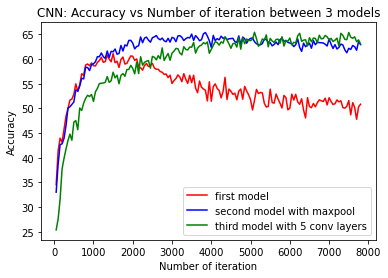

In [46]:
# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.plot(iteration_list2,accuracy_list2,color = "blue")
plt.plot(iteration_list3,accuracy_list3,color = "green")

plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration between 3 models")
plt.legend(['first model', 'second model with maxpool', 'third model with 5 conv layers'])
plt.show()

Slightly lower memory usage, similar accuracy to the previous model but it converges slower. This happens because there are more layers, with more convolution parameters to train, while reducing the fully connected parameters.

In [60]:
class CNNModel4(nn.Module):
  def __init__(self):
    super(CNNModel4, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    
    # convolution layer 1. using kernel_size = 5 to obtain the output of 28x28
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=1, padding=0)   
    self.relu1 = nn.ReLU() 
    
    # convolution layer 2. using kernel_size = 3 to obtain the output of 26x26
    self.cnn2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, stride=1, padding=0)   
    self.relu2 = nn.ReLU()
    # maxpool layer 1 added to obtain output of 13x13
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    
    # convolution layer 3. using kernel_size = 3 to obtain the output of 11x11    
    self.cnn3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=0)   
    self.relu3 = nn.ReLU() 
    
    # convolution layer 4. using kernel_size = 3 to obtain the output of 9x9    
    self.cnn4 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=0)   
    self.relu4 = nn.ReLU() 
    
    # convolution layer 5. using kernel_size = 3 to obtain the output of 7x7    
    self.cnn5 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=0)   
    self.relu5 = nn.ReLU() 
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    
    # Fully connected 1
    self.fc1 = nn.Linear(96 * 7 * 7, 120)
    self.relu4 = nn.ReLU()
    
    # Fully connected 2
    self.fc2 = nn.Linear(120, 84)
    self.relu5 = nn.ReLU()
    
    # Fully connected 3
    self.fc3 = nn.Linear(84, 10)
    
    self.i = 0

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    out = self.cnn1(x)
    out = self.relu1(out)      
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool1(out)
    
    if self.i == 0:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.i += 1

    out = self.cnn3(out)
    out = self.relu3(out)
    out = self.cnn4(out)
    out = self.relu4(out)
    out = self.cnn5(out)
    out = self.relu5(out)
    
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)    
    out = self.fc3(out)    
    
    return out

In [61]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model4 = CNNModel4()
model4.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 

optimizer4 = torch.optim.Adam(model4.parameters(), lr=learning_rate)


  0%|          | 0/20 [00:00<?, ?it/s]

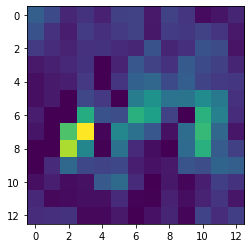

  5%|▌         | 1/20 [00:21<06:45, 21.33s/it]

Iteration: 500  Loss: 1.2672182321548462  Accuracy: 54.0099983215332 %


 10%|█         | 2/20 [00:43<06:35, 21.97s/it]

Iteration: 1000  Loss: 1.0334415435791016  Accuracy: 61.7599983215332 %


 15%|█▌        | 3/20 [01:06<06:17, 22.18s/it]

Iteration: 1500  Loss: 0.7224817276000977  Accuracy: 69.08999633789062 %


 25%|██▌       | 5/20 [01:51<05:34, 22.32s/it]

Iteration: 2000  Loss: 0.8392762541770935  Accuracy: 70.0199966430664 %


 30%|███       | 6/20 [02:11<05:06, 21.86s/it]

Iteration: 2500  Loss: 0.670225977897644  Accuracy: 69.91999816894531 %


 35%|███▌      | 7/20 [02:34<04:46, 22.03s/it]

Iteration: 3000  Loss: 0.5854135155677795  Accuracy: 71.33999633789062 %


 40%|████      | 8/20 [02:56<04:25, 22.15s/it]

Iteration: 3500  Loss: 0.3949741721153259  Accuracy: 70.48999786376953 %


 50%|█████     | 10/20 [03:41<03:42, 22.27s/it]

Iteration: 4000  Loss: 0.44109004735946655  Accuracy: 68.68000030517578 %


 55%|█████▌    | 11/20 [04:03<03:20, 22.31s/it]

Iteration: 4500  Loss: 0.3924218714237213  Accuracy: 68.29999542236328 %


 60%|██████    | 12/20 [04:24<02:55, 21.89s/it]

Iteration: 5000  Loss: 0.36824512481689453  Accuracy: 69.88999938964844 %


 70%|███████   | 14/20 [05:09<02:12, 22.13s/it]

Iteration: 5500  Loss: 0.5079470872879028  Accuracy: 68.0199966430664 %


 75%|███████▌  | 15/20 [05:31<01:51, 22.21s/it]

Iteration: 6000  Loss: 0.29775315523147583  Accuracy: 68.61000061035156 %


 80%|████████  | 16/20 [05:54<01:29, 22.26s/it]

Iteration: 6500  Loss: 0.21079687774181366  Accuracy: 68.8499984741211 %


 85%|████████▌ | 17/20 [06:15<01:05, 21.85s/it]

Iteration: 7000  Loss: 0.23195303976535797  Accuracy: 69.33999633789062 %


 95%|█████████▌| 19/20 [06:59<00:22, 22.12s/it]

Iteration: 7500  Loss: 0.2877177596092224  Accuracy: 69.0199966430664 %


100%|██████████| 20/20 [07:22<00:00, 22.12s/it]


In [62]:
count = 0
loss_list4 = []
iteration_list4 = []
accuracy_list4 = []
for epoch in tqdm(range(num_epochs)):
    model4.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer4.zero_grad()
        
        # TODO: Forward propagation
        outputs = model4(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer4.step()
        
        count += 1
        
        if count % 50 == 0:
            model4.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model4(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list4.append(loss.item())
            iteration_list4.append(count)
            accuracy_list4.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

In [63]:
from torchsummary import summary
print(summary(model4, input_size=(3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]           1,824
              ReLU-2           [-1, 24, 28, 28]               0
            Conv2d-3           [-1, 64, 26, 26]          13,888
              ReLU-4           [-1, 64, 26, 26]               0
         MaxPool2d-5           [-1, 64, 13, 13]               0
            Conv2d-6           [-1, 96, 11, 11]          55,392
              ReLU-7           [-1, 96, 11, 11]               0
            Conv2d-8             [-1, 96, 9, 9]          83,040
              ReLU-9             [-1, 96, 9, 9]               0
           Conv2d-10             [-1, 96, 7, 7]          83,040
             ReLU-11             [-1, 96, 7, 7]               0
           Linear-12                  [-1, 120]         564,600
           Linear-13                   [-1, 84]          10,164
           Linear-14                   

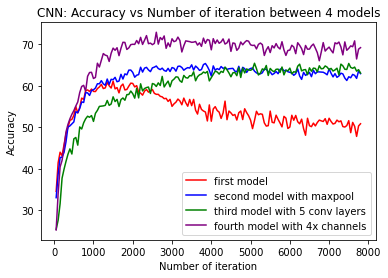

In [64]:
# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.plot(iteration_list2,accuracy_list2,color = "blue")
plt.plot(iteration_list3,accuracy_list3,color = "green")
plt.plot(iteration_list4,accuracy_list4,color = "purple")

plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration between 4 models")
plt.legend(['first model', 'second model with maxpool', 'third model with 5 conv layers', 'fourth model with 4x channels'])
plt.show()

This model manages a higher accuracy than the others, by a good margin. This is because there are more features to train on and detect from the images at each layer. The drawback to this model is the memory usage is higher than the previous 2, and it has longer training time.